In [ ]:
import os
import cv2
import json
import glob
import threading
import warnings
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, deltaE_cie76
from sklearn.exceptions import ConvergenceWarning

# Parse data path

In [2]:
keyframes_dir = './Keyframes'
all_keyframe_paths = dict()
for part in sorted(os.listdir(keyframes_dir)):
    data_part = part.split('_')[-1] # L01, L02 for ex
    all_keyframe_paths[data_part] =  dict()

for data_part in sorted(all_keyframe_paths.keys()):
    data_part_path = f'{keyframes_dir}/{data_part}'
    video_dirs = sorted(os.listdir(data_part_path))
    video_ids = [video_dir.split('_')[-1] for video_dir in video_dirs]
    for video_id, video_dir in zip(video_ids, video_dirs):
        keyframe_paths = sorted(glob.glob(f'{data_part_path}/{video_dir}/*.jpg'))
        all_keyframe_paths[data_part][video_id] = keyframe_paths

# Color


Custom Pallete


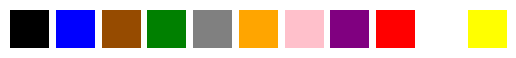

In [4]:
color_pallette ={
    'black' :  [0, 0, 0],
    'blue'  :  [0, 0, 255],
    'brown' :  [150, 75, 0],
    'green' :  [0, 128, 0],
    'grey'  :  [128, 128, 128],
    'orange':  [255, 165, 0],
    'pink'  :  [255, 192, 203],
    'purple':  [128, 0, 128],
    'red'   :  [255, 0, 0],
    'white' :  [255, 255, 255],
    'yellow':  [255, 255, 0]
}

n_colors = len(color_pallette)

print("Custom Pallete")
plt.figure(0)
for i, (_, value)  in enumerate(color_pallette.items()):
    patch = np.ones((20, 20, 3), dtype=np.uint8)
    patch[:, :, :] = value
    plt.subplot(1, n_colors, i+1)
    plt.axis('off')
    plt.imshow(patch)
plt.show()     

# Helper Function

In [5]:
class VisualEncoding:
  def __init__(self,
                classes = ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train',
                           'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
                           'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
                           'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella',
                           'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
                           'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
                           'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork',
                           'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
                           'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
                           'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
                           'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
                           'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
                           'scissors', 'teddy bear', 'hair drier', 'toothbrush'),
                colors = ('black', 'blue', 'brown', 'green', 'grey', 'orange_', 'pink', 'purple',
                          'red', 'white', 'yellow'),
                row_str = ["0", "1", "2", "3", "4", "5", "6"],
                col_str = ["a", "b", "c", "d", "e", "f", "g"]):
    self.classes = classes
    self.colors = colors
    self.classes2idx = dict()
    for i, class_ in enumerate(classes):
      self.classes2idx[class_] = i
    self.n_row = len(row_str)
    self.n_col = len(col_str)

    x_pts = np.linspace(0, 1, self.n_row+1)
    y_pts = np.linspace(0, 1, self.n_col+1)

    self.grid_bboxes = []
    self.grid_labels = []
    for i in range(self.n_row):
      for j in range(self.n_col):
        label = col_str[j] + row_str[i]
        self.grid_bboxes.append([x_pts[j], y_pts[i], x_pts[j+1], y_pts[i+1]])
        self.grid_labels.append(label)

    self.grid_bboxes = np.array(self.grid_bboxes)

In [6]:
def match_image_to_pallete(image_colors, pallete_colors, threshold = 0.07):
    #converts RGB to CIE 1976 L*a*b values. The CIELAB color space
    #(also known as CIE L*a*b*) is a color space defined by the
    #International Commission on Illumination (CIE) in 1976.
    h, w, _ = image_colors.shape
    n_pixels = h*w

    image_colors = rgb2lab(np.uint8(np.asarray(image_colors))).reshape(-1, 1, 3)
    pallete_colors = rgb2lab(np.uint8(np.asarray([pallete_colors]))).reshape(-1, 3)

    #Euclidean distance between two points in Lab color space.
    diff = deltaE_cie76(image_colors, pallete_colors)
    color_indices, color_frequencies = np.unique(np.argsort(diff)[:, :2].reshape(-1), return_counts=True)
    color_indices = color_indices[color_frequencies > n_pixels*threshold]
    return color_indices

In [7]:
encoder = VisualEncoding()
grid_bboxes = encoder.grid_bboxes
grid_labels = encoder.grid_labels
color_pallette_lst = list(color_pallette.values())
id2colors = [key for key in color_pallette.keys()]

# Run inference

In [8]:
def thread_helper(i, image, h, w):
    x0, y0, x1, y1 = grid_bboxes[i]
    x0, y0, x1, y1 = int(x0*w), int(y0*h), int(x1*w), int(y1*h)
    crop_image = image[y0:y1, x0:x1, :]
    color_indices = match_image_to_pallete(crop_image, color_pallette_lst)
    for color_idx in color_indices:
        context.append(grid_labels[i] + id2colors[color_idx])

In [ ]:
save_dir_all = 'context_encoded'
if not os.path.exists(save_dir_all):
    os.mkdir(save_dir_all)

save_dir = f'{save_dir_all}/colors_encoded'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for key, video_keyframe_paths in tqdm(all_keyframe_paths.items()):
    video_ids = sorted(video_keyframe_paths.keys())
    if not os.path.exists(os.path.join(save_dir, key)):
        os.mkdir(os.path.join(save_dir, key))

    for video_id in tqdm(video_ids):
        video_color_contexts = []
        video_keyframe_path = video_keyframe_paths[video_id]
        for image_path in video_keyframe_path:
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w, _ = image.shape
            context = []
            threads = []
            for i in range(len(grid_bboxes)):
                thread = threading.Thread(target=thread_helper, args=(i, image, h, w))
                thread.start()
                threads.append(thread)

            for i in range(len(grid_bboxes)):
                threads[i].join()

            context = ' '.join(map(str, context))

            video_color_contexts.append(context)

        if len(video_color_contexts) != len(video_keyframe_path):
            print("Something wrong!!!!!")
            break

        # Saving the video color context txt
        with open(f"{save_dir}/{key}/{video_id}.txt", "w") as f:
            for item in video_color_contexts:
                f.write("%s\n" % item)    